<a href="https://colab.research.google.com/github/rmedi21/challenge-telecom-x-2/blob/main/TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🔧 Extracción y Preparación

## Librerías

In [5]:
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imbpipeline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## Base de Datos

In [6]:
# CARGAR BASE DE DATOS
url = "https://raw.githubusercontent.com/rmedi21/challenge-telecom-x-2/refs/heads/main/TelecomX_Data_Depurada.csv"
df = pd.read_csv(url, delimiter=',')

In [7]:
# ELIMINAR COLUMNAS IRRELEVANTES
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df.drop(cols, axis=1, inplace=True)

In [8]:
# CAMBIAR NOMBRES DE VARIABLES
df.rename(columns={'PaperlessBilling': 'Tiene_Factura_Electronica',
                   'Churn': 'Cancelacion'},
          inplace=True)

## Funciones

In [9]:
def ancho_bin(df, columna):
    q1, q3 = np.percentile(df[columna], [25, 75])
    iqr = q3 - q1
    ancho = 2 * iqr * np.power(len(df[columna]), -1/3)
    return ancho


def matriz_correlacion(df, cols):
    corr = df[cols].corr()
    ancho = 9 if len(cols) > 10 else 6
    alto = 7 if len(cols) > 10 else 4
    mascara = np.zeros_like(corr, dtype=bool)
    mascara[np.triu_indices_from(mascara)] = True

    fig, ax = plt.subplots(figsize=(ancho, alto))
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    ax = sns.heatmap(
            corr, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0, square=True,
            linewidths=.5, annot=True, fmt=".2f",
            annot_kws={'size': 8}, cbar_kws={"shrink": .4}
         )
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)

    ax.set_title("Matriz de Correlaciones", y=1.0, fontsize=12)
    plt.xticks(fontsize=8.5, rotation=90)
    plt.yticks(fontsize=8.5)


def matriz_confusion(y_real, y_prev):
    mc = confusion_matrix(y_real, y_prev)

    fig, ax = plt.subplots(figsize=(4, 3))
    mc_grafico = ConfusionMatrixDisplay(confusion_matrix=mc, display_labels=['Permanece','Cancelado'])
    mc_grafico.plot(cmap='Blues', ax=ax)

    ax.set_xlabel('Valor previsto', fontsize=10, labelpad=10)
    ax.set_ylabel('Valor real', fontsize=10)
    ax.tick_params(axis='both', labelsize=9.5)
    fig.axes[1].tick_params(labelsize=9.5)   # cbar
    ax.set_title("Matriz de Confusion", y=1.02, fontsize=12)


def intervalo_confianza(scores):
    prom = scores.mean()
    desvest = scores.std()
    return f'[{(prom - 2 * desvest):.4f}, {min(prom + 2 * desvest, 1):.4f}]'

#📊 Análisis y Selección de Variables

## Análisis Dirigido

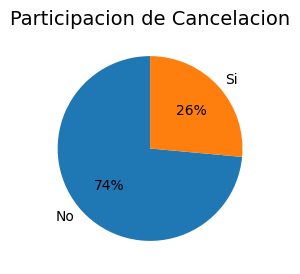

In [10]:
# Participacion de Cancelacion: 26% fuga, 74% permanece
plt.figure(figsize=(4, 3))
plt.pie(df['Cancelacion'].value_counts(), labels=['No','Si'], autopct='%1.0f%%', startangle=90)
plt.title('Participacion de Cancelacion', fontsize=14)

plt.show()
# plt.savefig("participacion_churn.png", bbox_inches='tight', dpi=300)
# plt.close()

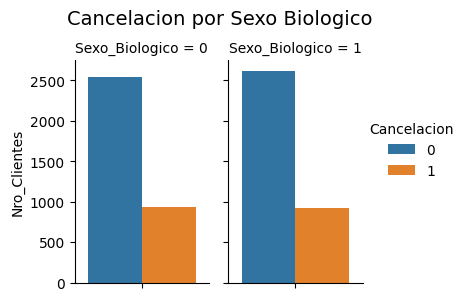

In [11]:
# Cancelacion por Sexo: el sexo no discrima la cancelacion
df2 = df.groupby(['Cancelacion', 'Sexo_Biologico'])['Cancelacion'].count()
df2 = df2.reset_index(name='Nro_Clientes')

ax = sns.catplot(
        data=df2, hue="Cancelacion", y="Nro_Clientes", col="Sexo_Biologico",
        kind="bar", height=2.8, aspect=.7
     )

ax.fig.suptitle("Cancelacion por Sexo Biologico", y=1.06, fontsize=14)

plt.show()
# plt.savefig("distribucion_churn_sexo.png", bbox_inches='tight', dpi=300)
# plt.close()

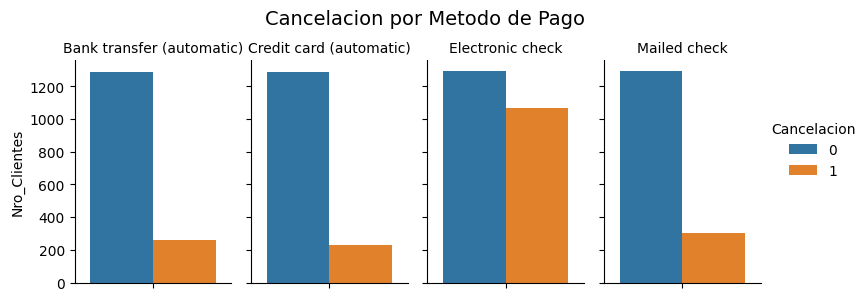

In [12]:
# Cancelacion por Metodo de pago:
# -El cheque electronico tiene una fuga considerablemente mayor comparado con los otros tipos de pago
df2 = df.groupby(['Cancelacion', 'Metodo_Pago'])['Cancelacion'].count()
df2 = df2.reset_index(name='Nro_Clientes')

ax = sns.catplot(
        data=df2, hue="Cancelacion", y="Nro_Clientes", col="Metodo_Pago",
        kind="bar", height=2.8, aspect=.7
     )

ax.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
ax.fig.suptitle("Cancelacion por Metodo de Pago", y=1.06, fontsize=14)

plt.show()
# plt.savefig("distribucion_churn_metodo_pago.png", bbox_inches='tight', dpi=300)
# plt.close()

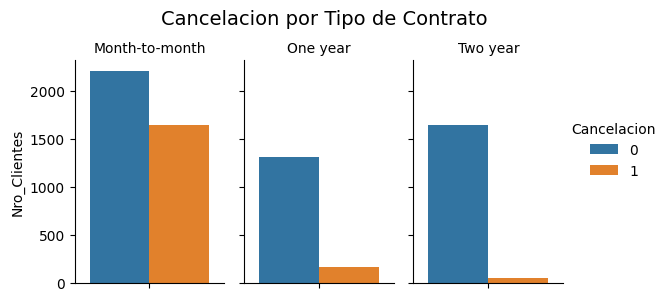

In [13]:
# Cancelacion por Tipo de contrato: el contrato mensual tiene concentra casi todos los clientes fugados
df2 = df.groupby(['Cancelacion', 'Tipo_Contrato'])['Cancelacion'].count()
df2 = df2.reset_index(name='Nro_Clientes')

ax = sns.catplot(
        data=df2, hue="Cancelacion", y="Nro_Clientes", col="Tipo_Contrato",
        kind="bar", height=2.8, aspect=.7,
     )

ax.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
ax.fig.suptitle("Cancelacion por Tipo de Contrato", y=1.06, fontsize=14)

plt.show()
# plt.savefig("distribucion_churn_tipo_contrato.png", bbox_inches='tight', dpi=300)
# plt.close()

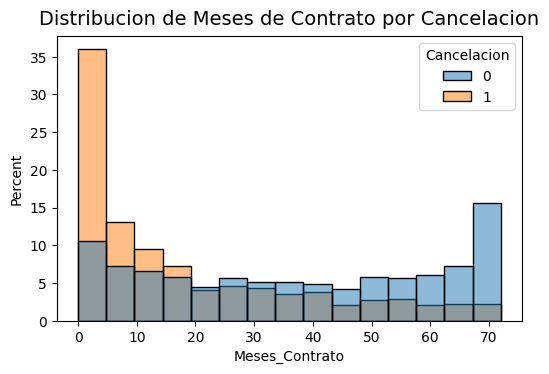

In [14]:
# Distribucion de Tiempo de Contrato por Cancelacion:
# -Los clientes cancelados tienen menos meses de contrato
# -A medida que aumentan el tiempo de contrato menos clientes cancelan
anchobin = ancho_bin(df, 'Meses_Contrato')

fig, ax = plt.subplots(figsize=(6, 3.7))

sns.histplot(
    data=df, x="Meses_Contrato", hue="Cancelacion",
    stat="percent", binwidth=anchobin, common_norm=False,
    ax=ax
)

plt.title("Distribucion de Meses de Contrato por Cancelacion", y=1.01, fontsize=14)

plt.show()
# plt.savefig("distribucion_meses_contrato_churn.png", bbox_inches='tight', dpi=300)
# plt.close()

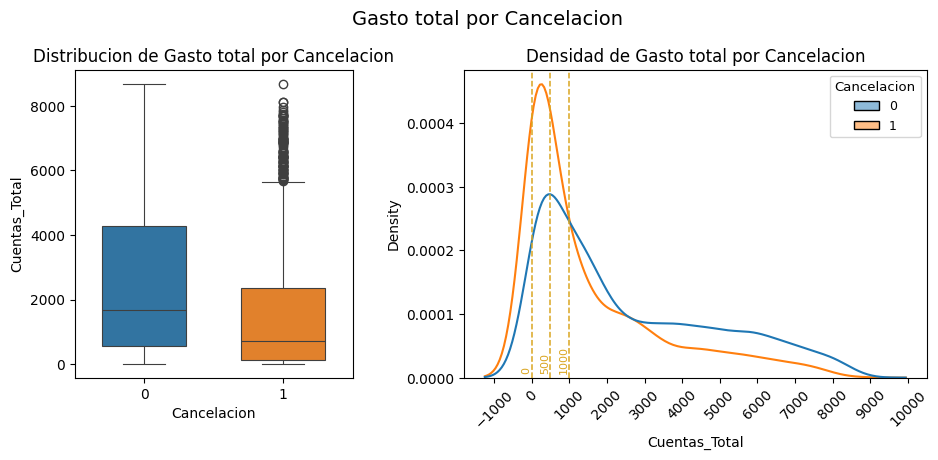

In [15]:
# Boxplot y Densidad del Gasto total por Cancelacion:
# -Los clientes cancelados y no cancelados tienen asimetria positiva:
#   -Alta concentracion de clientes con gastos bajos
#   -A medida que aumenta el gasto disminuye la cantidad de clientes
# -Sin embargo, los clientes cancelados tienen mayor concentracion en gastos bajos:
#   -El 50% de cancelados tiene un gasto < 713, los no cancelados un gasto < 1683 (mas del doble)
#   -El 75% de cancelados tiene un gasto < 2345, los no cancelados un gasto < 4264 (80% mas)
fig, axs = plt.subplots(1, 2, figsize=(11, 4), width_ratios=[1.2, 2])

# Boxplot
axs[0] = sns.boxplot(
            data=df, x='Cancelacion', y='Cuentas_Total', hue='Cancelacion',
            width=.6, linewidth=.8, legend=False,
            ax=axs[0]
         )
axs[0].set_title('Distribucion de Gasto total por Cancelacion', y=1, fontsize=12)

# Kdeplot
axs[1] = sns.kdeplot(
            data=df, x="Cuentas_Total", hue="Cancelacion",
            common_norm=False, legend=True,
            ax=axs[1]
         )
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1000))
axs[1].tick_params(axis='x', labelsize=10, labelrotation=45)
axs[1].axvline(x=0, linewidth=1.1, color='goldenrod', linestyle='--')
axs[1].axvline(x=500, linewidth=1.1, color='goldenrod', linestyle='--')
axs[1].axvline(x=1000, linewidth=1.1, color='goldenrod', linestyle='--')
axs[1].text(-20, 9E-6, '0', fontsize=8, color='goldenrod', ha='right', rotation=90)
axs[1].text(480, 9E-6, '500', fontsize=8, color='goldenrod', ha='right', rotation=90)
axs[1].text(980, 9E-6, '1000', fontsize=8, color='goldenrod', ha='right', rotation=90)
axs[1].set_title("Densidad de Gasto total por Cancelacion", y=1, fontsize=12)
# kdeplot - leyenda
handles = ax.legend_.legend_handles
texts = axs[1].legend_.texts
[handle.set_label(text.get_text()) for handle, text in zip(handles, texts)]
axs[1].legend(handles=handles, title='Cancelacion', prop={'size': 9}, loc='upper right', title_fontsize=9.5)

fig.suptitle("Gasto total por Cancelacion",  y=1.03, fontsize=14)
fig.subplots_adjust(wspace=0.3)

plt.show()
# plt.savefig("boxplot_densidad_gasto_total_churn.png", bbox_inches='tight', dpi=300)
# plt.close()

## Análisis de Correlaciones

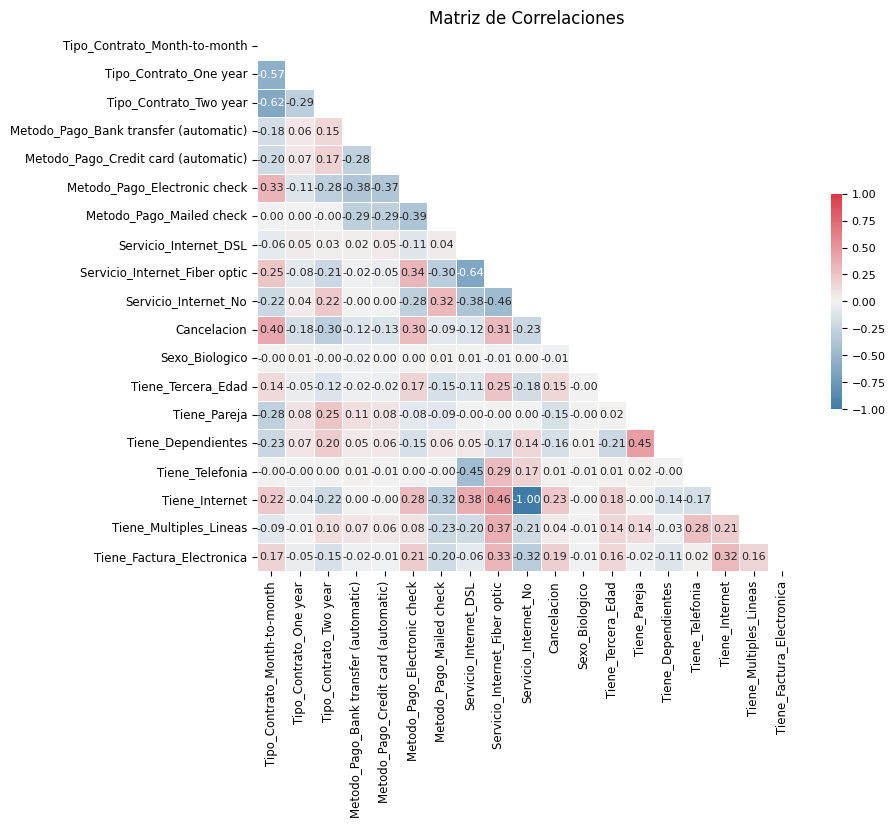

In [16]:
# CORRELACION DE VARIABLES CATEGORICAS
# -Nula correlacion entre Cancelacion con Sexo, Tiene telefonia y Tiene multiples lineas respectivamente
# -Baja correlacion entre Cancelacion con Tiene factura electronica, Tiene internet, Tiene pareja, Tiene dependientes y Tiene tercera edad
# -Moderada correlacion entre Cancelacion con Tipo de contrato, Metodo de pago y Servicio Internet
cols_cat = ['Tipo_Contrato', 'Metodo_Pago', 'Servicio_Internet']
cols = ['Cancelacion', 'Tipo_Contrato', 'Metodo_Pago', 'Servicio_Internet', 'Sexo_Biologico', 'Tiene_Tercera_Edad', 'Tiene_Pareja',
        'Tiene_Dependientes', 'Tiene_Telefonia', 'Tiene_Internet', 'Tiene_Multiples_Lineas', 'Tiene_Factura_Electronica']

one_hot = make_column_transformer((OneHotEncoder(drop='if_binary'), cols_cat),
                                  remainder='passthrough',
                                  sparse_threshold=0,
                                  force_int_remainder_cols=False)

arr = one_hot.fit_transform(df[cols])

func = np.vectorize(lambda x: x.split('__')[1])
cols2 = func(one_hot.get_feature_names_out(cols))
df2 = pd.DataFrame(arr, columns=cols2)
df2

matriz_correlacion(df2, cols2)
plt.show()
# plt.savefig("matriz_correlacion_categoricas.png", bbox_inches='tight', dpi=300)
# plt.close()

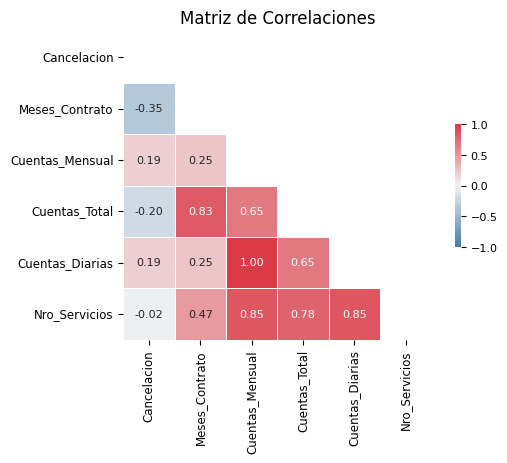

In [17]:
# CORRELACION DE VARIABLES NUMERICAS
# La Cancelacion tiene correlacion:
#   -Positiva moderada con los Meses de contrato
#   -Positiva debil con Cuentas diarias y Cuentas mensual
#   -Negativa debil con Cuentas total
#   -Casi nula con Numero de servicios
# -Cuentas mensual esta perfectamente correlacionado con Cuentas diarias
# -Numero servicios tiene muy alta correlacion con Cuentas total, mensual y diaria
cols = ['Cancelacion', 'Meses_Contrato', 'Cuentas_Mensual', 'Cuentas_Total', 'Cuentas_Diarias', 'Nro_Servicios']

matriz_correlacion(df, cols)
plt.show()
# plt.savefig("matriz_correlacion_numericas.png", bbox_inches='tight', dpi=300)
# plt.close()

## Selección de Variables

In [18]:
# SELECCION DE VARIABLES
# Se retiran las variables Sexo, Tiene telefonia y Tiene multiples lineas pues tienen nula correlacion con la Cancelacion
# Se retira Cuentas mensual, porque esta perfectamente correlacionado con Cuentas diarias
# Se retira Numero servicios, porque tiene casi nula correlacion con la Cancelacion y muy alta correlación con Cuentas total, mensual y diaria
# Se retira la variable Tiene internet en favor de la variable Servicio internet que tiene mejor correlacion
# Se mantienen las variables categoricas de Tipo de contrato, Metodo de pago y Servicio Internet por tener una correlacion moderada con la Cancelacion
# Se mantienen las variables numericas de Meses de contrato, Cuentas total y Cuentas diarias por tener una correlacion moderada con la Cancelacion
# Se mantienen las variables binarias Tiene factura electronica, Tiene pareja, Tiene dependientes y Tiene tercera edad, aún cuando tienen correlacion baja con la cancelacion
cols = ['Sexo_Biologico', 'Tiene_Telefonia', 'Tiene_Multiples_Lineas', 'Cuentas_Mensual', 'Nro_Servicios', 'Tiene_Internet']
df.drop(cols, axis=1, inplace=True)

## Codificación de Variables

In [19]:
# SEPARAR DATASET: Variable objetivo, Variables explicativas
y = df['Cancelacion']
X = df.drop('Cancelacion', axis=1)

In [20]:
# ONE HOT ENCODING VARIABLES CATEGORICAS
cols = X.columns
cols_cat = ['Tipo_Contrato', 'Metodo_Pago', 'Servicio_Internet']

one_hot = make_column_transformer((OneHotEncoder(drop='if_binary'), cols_cat),
                                  remainder='passthrough',
                                  sparse_threshold=0,
                                  force_int_remainder_cols=False)

X = one_hot.fit_transform(X)

In [21]:
# NORMALIZACION PARA VARIABLES NUMERICAS
# Modelo MIN-MAX para modelo KNN que maneja distancias
norm = MinMaxScaler()

#⚙️ Modelamiento Predictivo

In [22]:
# SEPARACION DE DATOS
# Se hace la division estratificada para mantener la proporcion de variable de respuesta
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=5)

In [23]:
y_train.value_counts() # mover

,count
Cancelacion,
0,3614
1,1300


In [24]:
y_test.value_counts() # mover

,count
Cancelacion,
0,1550
1,557


In [25]:
# MODELO BASE: Modelo de referencia basico para comparar modelos mas avanzados
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier()

In [26]:
# EVALUACION MODELO
# El score representa la mayor frecuencia de la variable respuesta (No = 0.74)
dummy.score(X_test, y_test)

0.7356430944470812

### Modelo KNN

In [27]:
# ENTRENAMIENTO MODELO
# Se normalizan las variables explicativas numericas pues el algoritmo KNN utiliza distancias
# -Una escala comun hace que las variables no tengan sesgos de escala y contribuyan equitativamente al modelo
X_train_norm = norm.fit_transform(X_train)

modelo_knn = KNeighborsClassifier()
modelo_knn.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [28]:
# EVALUACION MODELO (preliminar)
# Tiene mayor precision que el modelo base (0.84 vs 0.74)
X_test_norm = norm.transform(X_test)

print('****************** KNN ******************')
print(f'Exactitud en set de entrenamiento: {modelo_knn.score(X_train_norm, y_train):.4f}')
print(f'Exactitud en set de pruebas: {modelo_knn.score(X_test_norm, y_test):.4f}')

****************** KNN ******************
Exactitud en set de entrenamiento: 0.8462
Exactitud en set de pruebas: 0.7708


### Modelo Random Forest

In [29]:
# ENTRENAMIENTO MODELO
modelo_rf = RandomForestClassifier(max_depth=10, random_state=5)
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=5)

In [30]:
# EVALUACION MODELO (preliminar)
# Tiene mayor precision que KNN (0.87 vs 0.84)
# Existe diferencia marcada en los sets (train: 0.87, test: 0.79)
print('************* Random Forest *************')
print(f'Exactitud en set de entrenamiento: {modelo_rf.score(X_train, y_train):.4f}')
print(f'Exactitud en set de pruebas: {modelo_rf.score(X_test, y_test):.4f}')

************* Random Forest *************
Exactitud en set de entrenamiento: 0.8708
Exactitud en set de pruebas: 0.7883


# 📊 Evaluacion de Modelos

### Modelo KNN

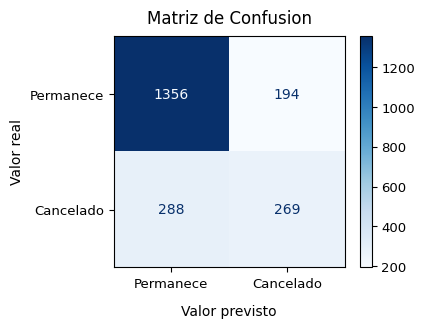

In [31]:
# MATRIZ DE CONFUSION
# Se predijo correctamente 269 clientes cancelados
# Se clasifico incorrectamente 288 clientes como permanecen pero son cancelados
# Se clasifico incorrectamente 194 clientes como cancelados pero son permanecen
X_test_norm = norm.fit_transform(X_test)
y_prev_knn = modelo_knn.predict(X_test_norm)

matriz_confusion(y_test, y_prev_knn)
plt.show()
# plt.savefig("matriz_confusion_modelo_knn.png", bbox_inches='tight', dpi=300)
# plt.close()

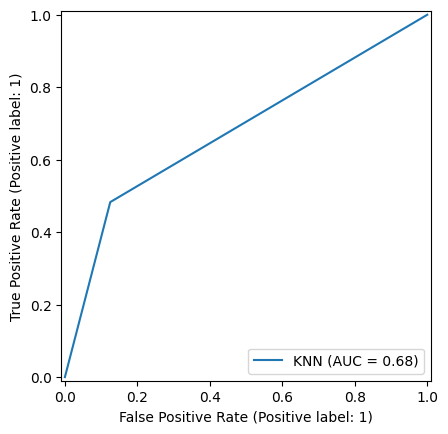

In [32]:
# CURVA ROC
# El AUC es alto (0.68) por lo tanto el modelo logra discriminar
RocCurveDisplay.from_predictions(y_test, y_prev_knn, name="KNN");

In [33]:
# METRICAS
# El objetivo es reducir la cancelacion, entonces se debe disminuir el error tipo 2 (falsos negativos)
# Por lo tanto, se debe optimizar la Sensibilidad
# La Sensibilidad es moderada (0.48)
print('******* Modelo KNN *******')
print(f'Precision:    {precision_score(y_test, y_prev_knn):.4f}')
print(f'Sensibilidad: {recall_score(y_test, y_prev_knn):.4f}')
print(f'Exactitud:    {accuracy_score(y_test, y_prev_knn):.4f}')
print(f'F1-score:     {f1_score(y_test, y_prev_knn):.4f}')

******* Modelo KNN *******
Precision:    0.5810
Sensibilidad: 0.4829
Exactitud:    0.7712
F1-score:     0.5275


### Modelo Random Forest

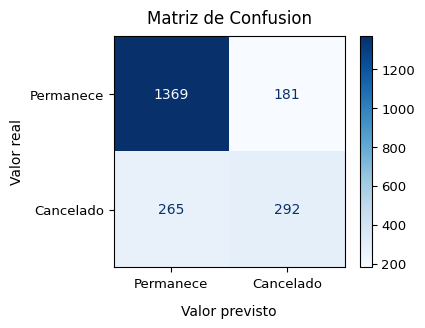

In [34]:
# MATRIZ DE CONFUSION
# Se predijo correctamente 292 clientes cancelados
# Se clasifico incorrectamente 265 clientes como permanecen pero son cancelados
# Se clasifico incorrectamente 181 clientes como cancelados pero son permanecen
y_prev_rf = modelo_rf.predict(X_test)

matriz_confusion(y_test, y_prev_rf)
plt.show()
# plt.savefig("matriz_confusion_modelo_rf.png", bbox_inches='tight', dpi=300)
# plt.close()

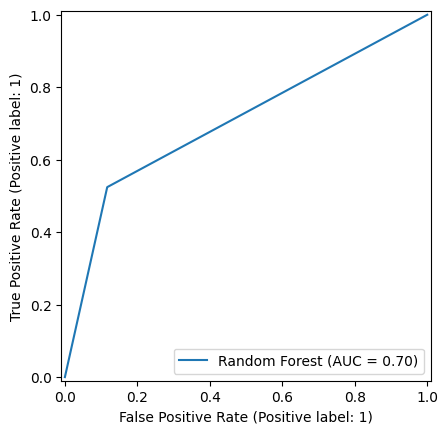

In [35]:
# CURVA ROC
# El AUC es alto (0.7) por lo tanto el modelo logra discriminar
RocCurveDisplay.from_predictions(y_test, y_prev_rf, name="Random Forest");

In [36]:
# METRICAS
# El objetivo es reducir la cancelacion, entonces se debe disminuir el error tipo 2 (falsos negativos)
# Por lo tanto, se debe optimizar la Sensibilidad
# La Sensibilidad es moderada (0.5242)
print('***** Modelo Random Forest *****')
print(f'Precision:    {precision_score(y_test, y_prev_rf):.4f}')
print(f'Sensibilidad: {recall_score(y_test, y_prev_rf):.4f}')
print(f'Exactitud:    {accuracy_score(y_test, y_prev_rf):.4f}')
print(f'F1-score:     {f1_score(y_test, y_prev_rf):.4f}')

***** Modelo Random Forest *****
Precision:    0.6173
Sensibilidad: 0.5242
Exactitud:    0.7883
F1-score:     0.5670


### VALIDACION

In [37]:
# VALIDACION CRUZADA CON BALANCEO DE DATOS Y PIPELINE
# Se utiliza pipeline para desbalancear los datos en la validacion
# Se valida el mejor modelo: Random Forest
# Se evaluara con la metrica de sensibilidad, para reducir el error tipo 2
modelo = RandomForestClassifier(max_depth=10)

In [38]:
# OVERSAMPING
# La sensibilidad es mayor a la del modelo (0.61 > 0.52)
pipeline = imbpipeline([('oversample', SMOTE()), ('rf', modelo)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_results = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')

intervalo_confianza(cv_results)

'[0.5411, 0.6896]'

In [48]:
# UNDERSAMPLING
# La sensibilidad mejora con respecto al oversampling (0.70 > 0.61)
pipeline = imbpipeline([('undersample', NearMiss(version=3)), ('rf', modelo)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_results = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')

# intervalo_confianza(cv_results)
cv_results

array([0.68461538, 0.77692308, 0.66538462, 0.68846154, 0.68076923])

In [47]:
# BALANCEO MIXTO
# La sensibilidad mejora con respecto al undersampling (0.74 > 0.70)
pipeline = imbpipeline([('smoteenn', SMOTEENN()), ('rf', modelo)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cv_results = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')

# intervalo_confianza(cv_results)
cv_results

array([0.71153846, 0.80384615, 0.76538462, 0.72692308, 0.75      ])

### PROBAR MODELO

In [41]:
# ENTRENAR MODELO CON DATA BALANCEADA
# Se utiliza el metodo SMOTEENN, pues obtuvo mejor sensibilidad en la validacion
balanceo = SMOTEENN()
x_balanced, y_balanced = balanceo.fit_resample(X_train, y_train)

modelo = RandomForestClassifier(max_depth=10)
modelo.fit(x_balanced, y_balanced)

RandomForestClassifier(max_depth=10)

In [43]:
# PREDICCION
y_prev = modelo.predict(X_test)

In [44]:
# METRICAS
# La sensibilidad es 0.75, la< cual es muy buena.
# El costo a asumir es el aumento en la precision (falsos positivos); paso de 0.62 a 0.53
print(classification_report(y_test, y_prev))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1550
           1       0.54      0.76      0.63       557

    accuracy                           0.76      2107
   macro avg       0.72      0.76      0.73      2107
weighted avg       0.80      0.76      0.78      2107



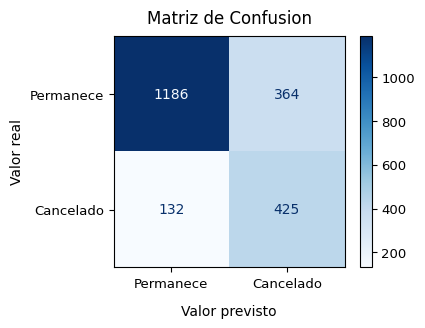

In [45]:
# MATRIZ CONFUSION
matriz_confusion(y_test, y_prev)
plt.show()

#📄Informe final

## Introducción
La empresa enfrenta una alta tasa de cancelaciones y necesita comprender los factores que llevan a la pérdida de clientes.

El objetivo de este proyecto es desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

Además de ello, se busca responder las siguientes preguntas:<br/>
¿Quienes son los clientes con mayor riesgo de cancelación?<br/>
¿Qué variables influyen más en este comportamiento?<br/>
¿Qué tipo de perfil necesita la empresa para mantenerse más cerca?


## Limpieza y Tratamiento de Datos


En lo que respecta a la limpieza de los datos, se realizaron las siguientes acciones:
* Eliminar columna código de cliente (*CustomerID*)
* Eliminar registros sin target (*Churn* con valor vacío [''])
* Identificar y eliminar registros duplicadas
* Corregir monto total:
 + Ajustar tipo de dato a *float*
 + Imputar monto total con valores vacíos
* Homologar valores:
 + No internet service -> No
 + No phone service -> No
* Feature Engineering:
 + Normalizar las variables numéricas con el método *Min Max Scaling*
 + Codificar las variables categoricas con *OneHot Encoding*
* Crear columnas:
 + Cuentas_Diarias = Cuentas_Mensual / 30
 + Tiene_Internet = Servicio_Internet in ('DSL', 'Fiber optic') -> 1, Servicio_Internet = 'No' -> 0
 + Nro_Servicios = Numero de servicios contratados

## Análisis Exploratorio de Datos
Una vez la base de datos se encuentra limpia y formateada, procedemos con el análisis descriptivo.
<br/>
* **Variables categóricas**<br/>
Se observa que el Churn por sexo biológico muestra igual proporción de clientes en ambos sexos:
<img alt='Distibucion de churn por sexo' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/distribucion_churn_sexo.png' width="450" height="315" />
<br/><br/>
Si analizamos por Método de pago, se observa que el cheque electrónico tiene mayor fuga que los otros métodos de pago, que presentan distribución en similar proporción:
<img alt='Distibucion de churn por metodo pago' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/distribucion_churn_metodo_pago.png' width="800" height="315" />
<br/><br/>
En el análisis por Tipo de contrato el contrato mensual tiene mayor fuga que los otros tipos:
<img alt='Distibucion de churn por tipo contrato' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/distribucion_churn_tipo_contrato.png' width="620" height="315" />
<br/><br/>
* **Variables numéricas**<br/>
Analizamos la distribucion del Total gastado por Churn utilizando un gráfico de densidad. Se observa que ambas distribuciones son semejantes:<br/>
    -Alta concentracion de clientes con gastos bajos<br/>
    -A medida que aumenta el gasto disminuye la cantidad de clientes
<img alt='Distibucion de total gastado por churn' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/densidad_cuenta_total_churn.png' width="630" height="450" />
<br/><br/>
* **Correlación de variables**<br/>
Se analizó la correlación de las variables numéricas con la variable objetivo obteniendo lo siguiente:<br/>
    -La correlación entre el Churn y los Meses de contrato es negativa y moderada<br/>
    -La correlación entre el Churn y las Cuentas diarias es positiva y débil<br/>
    -La correlación entre el Churn y el Número de servicio es es nula<br/>
<img alt='Matriz de correlaciones' src='https://raw.githubusercontent.com/rmedi21/challenge-telecom-x/refs/heads/main/img/matriz_correlaciones.png' width="450" height="420" />

## Entrenamiento
Para entrenar el modelo se escogieron los algoritmos KNN y Random Forest.

## Validación
Para la etapa de validación se realizó:
+ Matriz Confusión
+ Curva ROC
+ Métricas: nos centramos en la Sensibilidad, pues se quiere reducir el error tipo 2.
+ Validación cruzada y balanceo de datos: se utiliza un balanceo de datos, junto con una técnica de validación cruzada estratifica pax|ra evaluar la sensibilidad. Se utiliza para automatizar el proceso un pipeline.

Primero se analizan los modelos contra un modelo base, se identifica que el modelo de Random forest tiene mayor precisión, sin embargo, el objetivo planteado en el modelo predictivo de clientes cancelados es reducir los falsos negativos (clientes reales cancelados clasificados como clientes que permanecen), esto es, optimizar el Error tipo 2. Por ello ahora nos centramos en la métrica de sensibilidad.

## Conclusiones e Insights
- Se puede observar un comportamiento diferenciado para el Churn por la variable Meses de contrato y Cuentas diarias, según los gráficos analizados.
- Lo anterior se corrobora con la matriz de correlaciones, aunque se muestra una correlación moderada y débil respectivamente.
- Entonces una forma de reducir el Churn es hacer que el cliente se mantenga varios meses con el servicio y que su facturación diaria sea mínima.
<br/><br/>

## Recomendaciones
- Se recomienda balancear los datos debido a que los clientes que permanecen son la clase dominante (la relación es de 3 a 1 con los fugados).
- Se recomienda trabajar el modelo predictivo con las variables analizadas (Sexo_Biologico, Metodo_Pago, Meses_Contrato, Cuentas_Diarias, Numero_Servicios).